# Building a deep convolutional neural network

For this last machine learning assignment we'll complete the journey to modern deep neural networks, using *Tensorflow* to define whole layers of the network, instead of writing a single Logistic regression unit by hand as in the first module. For this module we'll look at a few more interesting additions you can make to a neural network and practice using *Tensorflow* to build the network.

As we arrive at more modern neural networks, we'll also quickly need *a lot* more computing power to optimize all the many weights that make up such a network. Running the assignment below on your own CPU is technically possible, but things will go much faster if you use a GPU (i.e. graphics card) to do the heavy lifting.

Having your code run on the GPU using *Tensorflow* is pretty straightforward, but does of course require that your computer has a good GPU (not standard and expensive). In addition, you'll need to separately install the GPU support for *Tensorflow*. If you have a good graphics card and would like to install this yourself, you can try this, but it is not recommended for this assignment. If you'd still like to try, instructions can be found here: https://www.tensorflow.org/install/gpu

## Google Colab

The easiest way to run your code on a GPU is probably using **Google Colab**, which is what we recommend you also use for this assignment. Google offers computing resources completely for free to anyone with a Google account. A *Colab* is a Jupyter notebook that is not running on your own computer, but on one of Google's many cloud computers. In order to run this notebook as a Colab, go to https://colab.research.google.com/

On the Colab page, select *Upload*, upload this `.ipynb` file and continue with the assignment there. Running a code cell on the Colab page will now actually run the code on a Google computer and not on your own machine!

Next we'll switch to a machine that has access to a GPU. In the menu at the top, select **Runtime** and then **Change runtime type**. Select the GPU hardware accelerator and Save. Now, any code you run will run on a Google GPU, which will make training your neural network much faster!

To check that everything works, run the code cell below:


In [ ]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


If everything is working correctly, you should see a single GPU listed as the device for this machine.

Google is offering quite an expensive resource to people for free, so there are some restrictions you should take into account. If you are inactive in the Colab for a while, you will get disconnected from the machine and it will be reassigned to someone else. If you use too much memory, either RAM or harddisk, you'll also get disconnected and have to reconnect to a new machine.

Note that any time you get disconnected, switch runtime or restart the runtime, you will have to reconnect to a new machine. When this happens the whole notebook will be restarted, so you'll have to run any code cells, that for example load the data, again. Having to restart and rerun the cells can be a bit annoying, but it is a small inconvenience for getting free access to a GPU.

## CIFAR-10 dataset

Speaking of loading the data, run the cell below to download the CIFAR-10 dataset on this machine.


In [ ]:
!curl -O https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  13.7M      0  0:00:11  0:00:11 --:--:-- 17.1M
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


The CIFAR-10 dataset is a classic dataset for deep learning and was originally created by Alex Krizhevsky. Start by reading the description of the dataset here: https://www.cs.toronto.edu/~kriz/cifar.html

Take a look at the format of the images and the random samples from the 10 classes shown on the page there, and make sure you understand the classification task from the dataset before continuing.

Below is some code to further unpack and prepare these 60.000 images. There are a couple of important things done as part of loading the data:

* Each image is reshaped back to 32 x 32 pixels and 3 color channels using [np.reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) 
* Each of the labels is transformed into a *one-hot encoding* using the [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) function.
* The 5 separate files of training data are merged to a single *Numpy* array using [np.vstack](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html)

In [ ]:
import os
import pickle
import numpy as np

def unpickle(filename):
    with open(filename, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
        images = [img.reshape((32,32,3), order='F') for img in data[b'data']]
        
        labels = tf.keras.utils.to_categorical(data[b'labels'])
        return (np.array(images), labels)


train_images, train_labels = [np.vstack(tr) for tr in zip(*[
        unpickle(os.path.join('cifar-10-batches-py', f'data_batch_{i+1}')) for i in range(5)])]

test_images, test_labels = unpickle(os.path.join('cifar-10-batches-py', 'test_batch'))

## Model evaluation function

Next up we'll provide a function that you can use for training your neural networks. This function takes a neural network `model`, training and validation data, and does a couple of things:

* Compiles the model using
    * a [CategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) loss function. This is the same classification error function we used in combination with the Softmax activation.
    * an additional metric of [Accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy), to see how well the predictions match the actual labels.
    * an [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer, which is a more advanced version of the gradient descent algorithm we've used up to this point to optimize the weights.
* Creates a preprocessing [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) for the training and validation data.
* Fits the compiled model using the preprocessed training data for the specified number of *epochs*.
* Plots the loss and accuracy for the training and validation data for each epoch.
* Prints the final validation accuracy.

We'll dive more deeply into what the preprocessing steps can do exactly in later sections. For now, no preprocessing is applied. Make sure you understand what all the other steps do before moving on to the next section.

In [ ]:
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, preprocessing

def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)

    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'accuracy']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")

## Creating a basic CNN model

Below is a basic Convolutional Neural Network with 2 convolutional layers. The first layer has 32 filters and the second one has 64 filters. After each convolutional layer a max pooling layer is applied. Next, after the convolutional layers, a fully connected layer with 256 hidden nodes is applied, and finally a softmax layer with 10 outputs for each of the 10 classes.

Using the function from above, this model is then fitted on training data and evaluated on the validation data. You should get a validation accuracy of about *61%*. This means that already *61%* of the validation images is correctly classified as 1 of the 10 possible classes. Clearly, the network is learning something, as a random prediction for the validation set should result in about *10%* accuracy. Looking at the learning curves it also seems like the network is indeed learning something, although there is clearly room for improvement too.

Incrementally improving this network will be the core task of this assignment. For each subsequent improvement you should copy the network from the previous cell and make the new improvements in addition to the other improvements already made. You should of course start with the basic model provided here and the goal will be to improve the validation accuracy as much as possible.


Epoch 1/20
1563/1563 [==============================] - 19s 10ms/step - loss: 2.2094 - accuracy: 0.4160 - val_loss: 1.3492 - val_accuracy: 0.5182
Epoch 2/20
1563/1563 [==============================] - 15s 10ms/step - loss: 1.2538 - accuracy: 0.5575 - val_loss: 1.2625 - val_accuracy: 0.5573
Epoch 3/20
1563/1563 [==============================] - 15s 10ms/step - loss: 1.0836 - accuracy: 0.6214 - val_loss: 1.1502 - val_accuracy: 0.6029
Epoch 4/20
1563/1563 [==============================] - 15s 10ms/step - loss: 0.9533 - accuracy: 0.6669 - val_loss: 1.1577 - val_accuracy: 0.6129
Epoch 5/20
1563/1563 [==============================] - 15s 10ms/step - loss: 0.8304 - accuracy: 0.7107 - val_loss: 1.2010 - val_accuracy: 0.6106
Epoch 6/20
1563/1563 [==============================] - 15s 10ms/step - loss: 0.7309 - accuracy: 0.7454 - val_loss: 1.2616 - val_accuracy: 0.6189
Epoch 7/20
1563/1563 [==============================] - 15s 10ms/step - loss: 0.6246 - accuracy: 0.7835 - val_loss: 1.2870 -

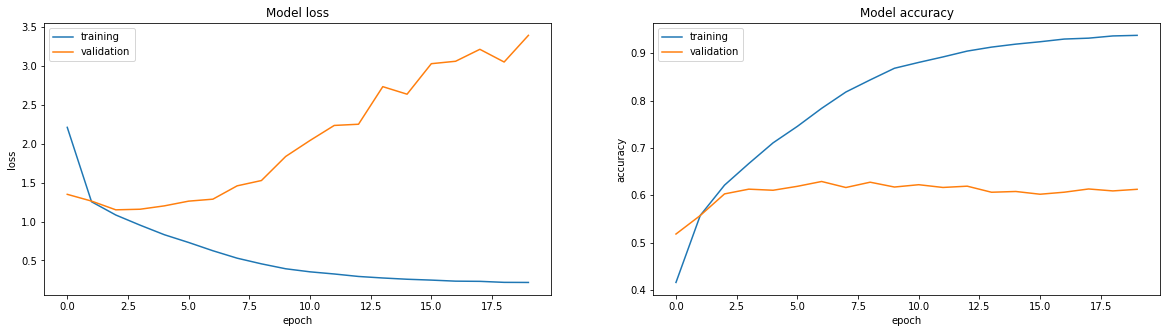

313/313 [==============================] - 2s 5ms/step - loss: 3.3910 - accuracy: 0.6126
Validation Accuracy: 0.6126000285148621


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, test_images, test_labels)

Part of the assignment will also be to analyse the learning curves at each step to see if a specific improvement is likely to increase the validation accuracy. However, there is one important thing to note about these curves, which might be confusing otherwise. The training cost at each epoch is computed as the *average training cost* of all the batches in the epoch. This means for the first few batches the cost will probably be higher and will get lower with subsequent batches. The validation cost is computed after all the batches have been processed, meaning this cost can actually be *lower* than the training cost.

Normally, you would expect the training cost to always be lower than the validation cost, but because the training cost is computed as an average (which is more efficient) this might not be the case. The general shape of the training curve, especially for later iterations, will still be correct and so is still useful for analysis in the same way.

**Q1. Explain why you would normally expect the training cost to always be lower than the validation cost.**

*The training cost indicates how well the model is fitting the training data. That cost should be low compared to the validation cost because the model has been trained on the training data. Contrastingly, the validation loss indicates how well the model fits new data. That cost can be expected to be relatively high because the model has not been trained on that data.*
*

### Assignment 1: Normalizing the input data

The basic CNN model seems to clearly be overfitting, but before we address that, we'll start by normalizing the input. This is a first step that is important for many ML models, but specifically for deep neural networks, as ReLU activations are only actually non-linear around an input of 0 (where the input switches from 0 to a linear output). This means that, for the ReLU activations to really be effective, you would want the average combined inputs to end up around 0, which is why *mean centering the data* is so important.

You could use something like `np.mean` to compute the average input in all the training images and then subtract that average from every input, but the easiest way is to use the data preprocessor [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). To use this together with the `train_and_evaluate()` function, you'll need to use the optional `preprocess` argument, which is a [keyword argument dictionary](https://docs.python.org/3/glossary.html#term-argument).

Each key in the *keyword argument dictionary* should be a string of the keyword you want to pass to the function and the value in the dictionary should be the corresponding parameter value you want to pass to the function. In order to mean center the data, we want to enable `featurewise_center`, so that would look like

    preprocess = {'featurewise_center': True}

Use this keyword argument dictionary to enable mean centering the data as a preprocessing step. In addition, the training data should be normalized to have a standard deviation of 1, for which there is also a keyword argument. The `train_and_evaluate()` function will then apply these same preprocessing steps to both the training and the validation data.

Start by copying the model from the cell before and then modify the `train_and_evaluate()` call to apply the mean centering and standard deviation normalization preprocessing to your data. If done correctly, your validation accuracy should increase to about *70%*.


**Q2. Explain why normalizing your image features (i.e. pixels) to have a standard deviation of 1 might also be important for deep neural networks with ReLU activations.**

*Batch normalization normalizes the hidden mean and variance, to have some fixed mean and variance. This can prevent overfitting. ReLu functions have values between zero and Z. A standard deviation of 1 would also normalize this in order to prevent outliers so that the average deviations will be more in between this (sd of 1). It would also prevent overfitting in this way.*

**Q3. Explain why it is so important you apply the same normalization to your training and validation data. What would happen if the function did not do this?**

*Because a model that does apply normalization and a model that does not, have different results. So, you'd get different results as the outcome of the test and validation data represent different models (with different normalizations). In order to accurately evaluate the functioning of the model, you should apply the exact same normalization to both the training and validation data.*

Epoch 1/20
1563/1563 [==============================] - 16s 10ms/step - loss: 1.1751 - accuracy: 0.5839 - val_loss: 0.9585 - val_accuracy: 0.6663
Epoch 2/20
1563/1563 [==============================] - 15s 10ms/step - loss: 0.7895 - accuracy: 0.7228 - val_loss: 0.8168 - val_accuracy: 0.7201
Epoch 3/20
1563/1563 [==============================] - 15s 10ms/step - loss: 0.5946 - accuracy: 0.7902 - val_loss: 0.8335 - val_accuracy: 0.7206
Epoch 4/20
1563/1563 [==============================] - 15s 10ms/step - loss: 0.4218 - accuracy: 0.8536 - val_loss: 0.8808 - val_accuracy: 0.7269
Epoch 5/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.2742 - accuracy: 0.9055 - val_loss: 1.0487 - val_accuracy: 0.7235
Epoch 6/20
1563/1563 [==============================] - 15s 10ms/step - loss: 0.1790 - accuracy: 0.9377 - val_loss: 1.0984 - val_accuracy: 0.7315
Epoch 7/20
1563/1563 [==============================] - 15s 10ms/step - loss: 0.1305 - accuracy: 0.9543 - val_loss: 1.2737 -

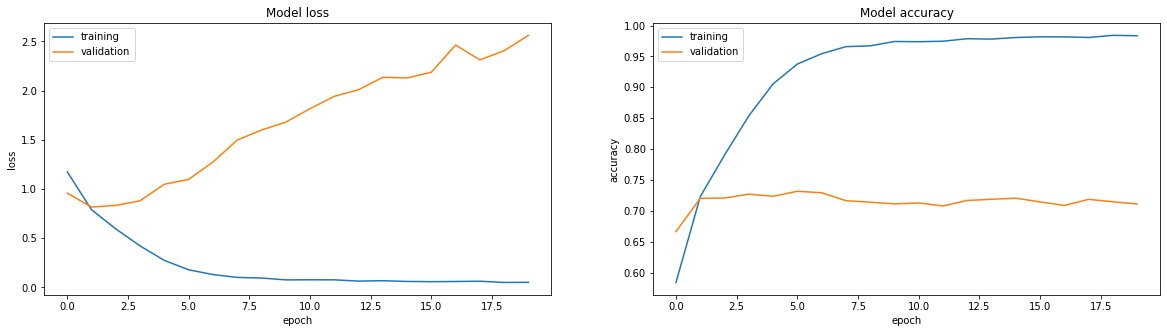

313/313 [==============================] - 2s 6ms/step - loss: 2.5625 - accuracy: 0.7111
Validation Accuracy: 0.7110999822616577


In [ ]:
# copy code from before
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# set preprocesing dictionary
preprocess = {'featurewise_center': True, 'featurewise_std_normalization' : True}

# run training and evaluation function
train_and_evaluate(model, train_images, train_labels, test_images, test_labels, preprocess)

### Assignment 2: Adding Dropout

Looking at the learning curves from the previous cell, it seems like the model is definitely overfitting. An easy and effective way to address this can be adding dropout layers to the network. [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers are already included in `tensorflow` and all you need to specify for this layer is the probability for each input to be dropped (i.e. for the input to be set to 0).

Copy your code from the previous cell and add dropout layers to your network. You should add a Dropout layer before each of the 2 Dense layers, both with a probability of *0.4*, so approximately *40%* of the inputs of these layers will be set to 0! As you want to maintain more of the network activations closer to the network input, only add a Dropout layer before the *last* Conv2D layer, with a lower dropping probability of *0.2*. If done correctly, your validation accuracy should increase to about *76%*.


**Q4. Explain what part exactly of the learning curves from the previous cell showed that the model was overfitting.**

*The part where training accuracy is higher than the validation accuracy typically indicates overfitting. Additionally, overfitting is also indicated by the fact that the training loss seems to go down whereas the validation loss starts to go up. You'd expect the validation loss to go down as over time (each epoch) as the model should be able to more accurately label the validation data. Since this is not the case, the model is overfitting and not generelizing well. The point where the validation loss is going up, starts to overfit. So, with this info combined I'd say that overfitting starts to occur at around 2 (where the validation cost is going up and the validation accuracy is not going up anymore.*

**Q5. Explain in your own words why adding dropout reduces the chance of the model overfitting.**

*Dropout changes the network by randomly dropping neurons from the neural network during training in each iteration. We train the same network in different ways. It makes the model less dependant on the contents of specific pixels so that it reduces the chances of overfitting. So, dropout reduces the chances of overfitting because the model becomes more robust so that it can better generelize.*

Epoch 1/20
1563/1563 [==============================] - 17s 11ms/step - loss: 1.4657 - accuracy: 0.4710 - val_loss: 1.0913 - val_accuracy: 0.6162
Epoch 2/20
1563/1563 [==============================] - 16s 10ms/step - loss: 1.1390 - accuracy: 0.5965 - val_loss: 0.9500 - val_accuracy: 0.6686
Epoch 3/20
1563/1563 [==============================] - 16s 10ms/step - loss: 1.0180 - accuracy: 0.6406 - val_loss: 0.9108 - val_accuracy: 0.6843
Epoch 4/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.9434 - accuracy: 0.6696 - val_loss: 0.8622 - val_accuracy: 0.6986
Epoch 5/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8926 - accuracy: 0.6883 - val_loss: 0.8450 - val_accuracy: 0.7149
Epoch 6/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8499 - accuracy: 0.7032 - val_loss: 0.7963 - val_accuracy: 0.7269
Epoch 7/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8104 - accuracy: 0.7140 - val_loss: 0.7739 -

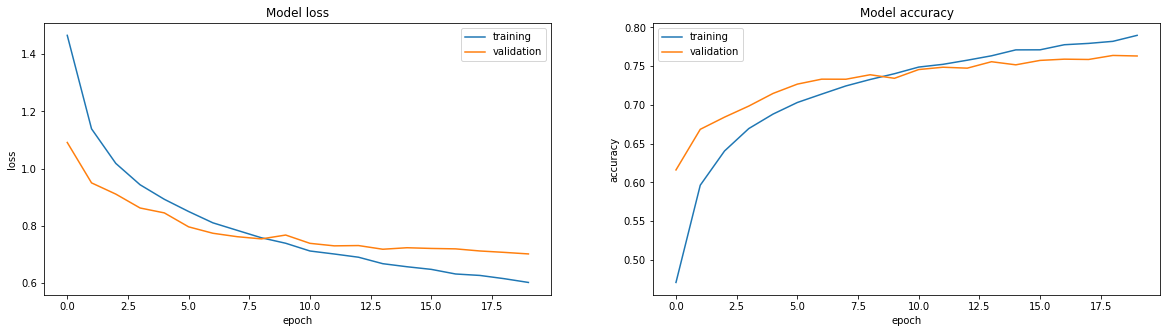

313/313 [==============================] - 2s 6ms/step - loss: 0.7016 - accuracy: 0.7632
Validation Accuracy: 0.7631999850273132


In [ ]:
# YOUR CODE HERE
model = models.Sequential()

# add dropout layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# add dropout layer
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

# add dropouts layer
model.add(tf.keras.layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))

# add dropouts layer
model.add(tf.keras.layers.Dropout(0.4))
model.add(layers.Dense(10, activation='softmax'))

# set preprocesing dictionary
preprocess = {'featurewise_center': True, 'featurewise_std_normalization' : True}

# run training and evaluati8on function
train_and_evaluate(model, train_images, train_labels, test_images, test_labels, preprocess)

Looking at the learning curves, the network also doesn't seem to be overfitting any more! An important thing to note about the training cost here is that it may again become higher than the validation cost. During training, dropout is active and some of the inputs get dropped, but when evaluating the validation data, all inputs are used, probably resulting in better prediction and thus a lower cost. To get a better estimate of the true training cost, we would need to add a full evaluation of the training data at each epoch too, but then we'd effectively double the computation for training data at each epoch, making the algorithm much slower. The training cost's current curve still has a useful shape for analysis, but the true training cost would be lower at every epoch.

### Assignment 3: Making the network deeper

Now that the network doesn't appear to be overfitting anymore, we can again try to add more complexity to the network and try to make it deeper. This should allow the network to learn more high level features and therefore hopefully improve performance further. 

Start by copying the code from the previous cell and add 2 more Conv2D layers to the network; the first one with 128 filters and the second one with 256 filters. The new layers should be inserted after the existing convolutional layers, and both convolutional layers should have a Dropout layer *before* and a MaxPooling layer *after* (i.e. the same structure as the last convolutional layer).

As the network is now deeper, it will also take longer to train, so increase the number of epochs in `train_and_evalute()` to *50*. If all steps are done correctly, your validation accuracy should increase to about *80%*.


Epoch 1/50
1563/1563 [==============================] - 24s 15ms/step - loss: 1.5566 - accuracy: 0.4259 - val_loss: 1.1317 - val_accuracy: 0.5991
Epoch 2/50
1563/1563 [==============================] - 23s 15ms/step - loss: 1.1830 - accuracy: 0.5771 - val_loss: 1.0320 - val_accuracy: 0.6321
Epoch 3/50
1563/1563 [==============================] - 23s 15ms/step - loss: 1.0512 - accuracy: 0.6273 - val_loss: 0.8823 - val_accuracy: 0.6927
Epoch 4/50
1563/1563 [==============================] - 23s 15ms/step - loss: 0.9836 - accuracy: 0.6526 - val_loss: 0.8225 - val_accuracy: 0.7130
Epoch 5/50
1563/1563 [==============================] - 23s 15ms/step - loss: 0.9319 - accuracy: 0.6738 - val_loss: 0.8639 - val_accuracy: 0.6956
Epoch 6/50
1563/1563 [==============================] - 23s 15ms/step - loss: 0.8994 - accuracy: 0.6855 - val_loss: 0.7943 - val_accuracy: 0.7218
Epoch 7/50
1563/1563 [==============================] - 23s 15ms/step - loss: 0.8743 - accuracy: 0.6970 - val_loss: 0.7744 -

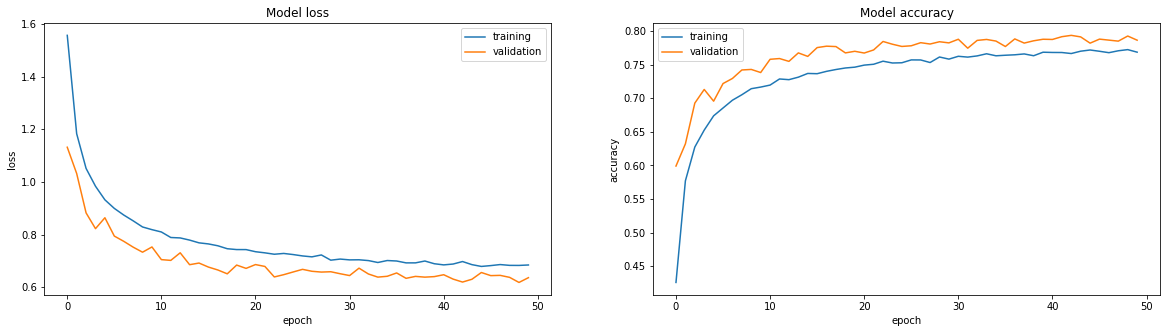

313/313 [==============================] - 2s 7ms/step - loss: 0.6363 - accuracy: 0.7863
Validation Accuracy: 0.786300003528595


In [ ]:
# YOUR CODE HERE
model = models.Sequential()

# add dropout layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# add dropout layer
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# add Conv2D layer with 128 filters
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# add Conv2D layer with 256 filters
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

# add Conv2D layer with 256 filters
model.add(tf.keras.layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(layers.Dense(10, activation='softmax'))

# set preprocesing dictionary
preprocess = {'featurewise_center': True, 'featurewise_std_normalization' : True}

# run training and evaluation function with 50 epochs
train_and_evaluate(model, train_images, train_labels, test_images, test_labels, preprocess, epochs = 50)

As a last step, this code cell should print a summary of the `model` you've now constructed, with information about each of the added layers. Also run this cell and study the output produced there.

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 8, 8, 64)         

**Q6. Which layer has the largest total output volume (i.e. total number of nodes)? Explain why this layer has the most nodes.**

*The first layer because that has a volume of 32x32x32. so, that's the largest. It has the most nodes because maxpooling reduces the number of nodes.

kernel size * kerel size * nr. channel input layer * nr. chanels output layer (filter) + bias nodes (nr. of filters (outputs). *

**Q7. Which layer has the largest number of trainable parameters  (i.e. weights)? Explain why this layer has the most weights.**

*The last layer. This layer has the most weights because the network starts with the highest volume and ends with the highest number of parameters, so the final layer has the most weights for the different parameters.*

### Assignment 4: Adding Batch Normalization

Now that the network is deeper, we might also benefit from applying batch normalization. With the preprocessing step at the start of this notebook the input features were normalized to have a 0 mean and standard deviation of 1, which helped the network learn mostly on the first layer with ReLU activations. With batch normalization this same type of scaling can be applied at each of the layers.

Start by copying the code from the previous cell and add a [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) layer after each MaxPooling layer. Effectively, this places the BatchNormalization layers *before* each of the layers with ReLU activations, except for the input layer (which has already been normalized). If done correctly, your validation accuracy should increase to about 84%.


**Q8. Explain in your own words why adding batch normalization improves the results of deep networks.**

*Normalizing the input features to mean zero and variance 1, does this for each layer, which speeds up the process because it reduces the number of training epochs required to train deep networks.  

Batch normalization also ensures that the model improves at the beginning, as the model improves and each epoch can train with an improved model, based on the normalisation. 
Furthermore, batch normalization makes sure that the means are centered around the part of the ReLU activation function that are not linear, so that the network can learn non-linear functions. 

Additionally, Andrew Ng explained that it enables the model to handle internal covariate shift. Batch normalization makes the weights and parameters in later layers (e.g. layer 5) more sensitive to weights in previous weights which facilitates generalisation. The values in the internal layers basically keep changing. So: if new images have a slightly different distribution from the previous images (e.g. white dogs instead of black dogs), the model will change its parameters according to these new images to still make accurate predictions.*

**Q9. The BatchNormalization layer also has two learnable parameters, $\beta$ and $\gamma$, which start learning at 0 and 1 respectively. Do you expect these parameters to change a lot when using the layer before a ReLU activation? Why or why not?**

We don't expect the gamma to change a lot because this is the standard deviation. It's mostly dependant on the data and assuming symmetrical data, I don't expect the parameter to change a lot depending on the RELU. 

I would, however expect the beta parameter to change a lof when used before a ReLU activation at the beginning of runnign the model. Because the Relu activation is quite rigid in the sense that it sets the inputs to values above 0 and below z. so this can definately change the mean at the beginning of running the model. However, as time progresses, the parameters get normalised as we use batch normalization. So the more often we use batch normalization, the less i would expect the beta parameter to change before a ReLU. 

**

Epoch 1/20
1563/1563 [==============================] - 26s 16ms/step - loss: 1.6136 - accuracy: 0.4428 - val_loss: 1.1171 - val_accuracy: 0.6005
Epoch 2/20
1563/1563 [==============================] - 25s 16ms/step - loss: 1.1633 - accuracy: 0.5910 - val_loss: 0.9180 - val_accuracy: 0.6757
Epoch 3/20
1563/1563 [==============================] - 25s 16ms/step - loss: 1.0130 - accuracy: 0.6431 - val_loss: 0.8356 - val_accuracy: 0.7086
Epoch 4/20
1563/1563 [==============================] - 26s 16ms/step - loss: 0.9248 - accuracy: 0.6775 - val_loss: 0.8004 - val_accuracy: 0.7265
Epoch 5/20
1563/1563 [==============================] - 25s 16ms/step - loss: 0.8558 - accuracy: 0.7031 - val_loss: 0.7312 - val_accuracy: 0.7504
Epoch 6/20
1563/1563 [==============================] - 25s 16ms/step - loss: 0.8035 - accuracy: 0.7221 - val_loss: 0.6720 - val_accuracy: 0.7686
Epoch 7/20
1563/1563 [==============================] - 25s 16ms/step - loss: 0.7636 - accuracy: 0.7363 - val_loss: 0.6559 -

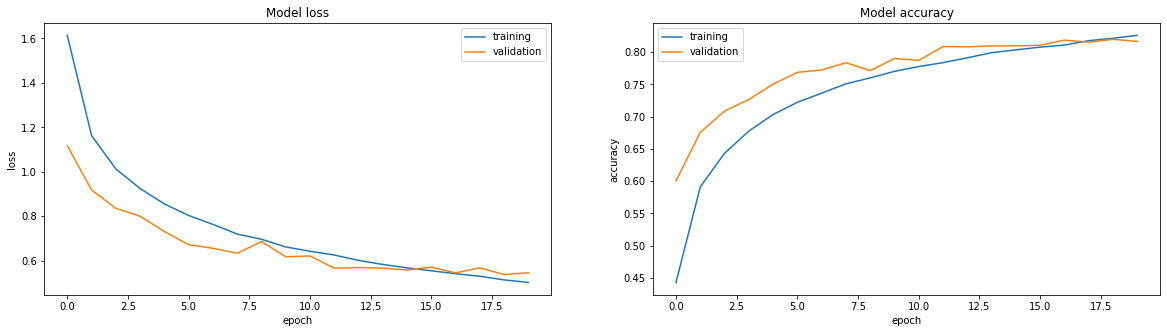

313/313 [==============================] - 2s 7ms/step - loss: 0.5458 - accuracy: 0.8165
Validation Accuracy: 0.8165000081062317


In [ ]:
# YOUR CODE HERE
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# add batchnormalization layer
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# add batchnormalization layer
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# add batchnormalization layer
model.add(tf.keras.layers.BatchNormalization())
model.add(layers.Flatten())
model.add(tf.keras.layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(layers.Dense(10, activation='softmax'))

# set preprocesing dictionary
preprocess = {'featurewise_center': True, 'featurewise_std_normalization' : True}

# run training and evaluati8on function
train_and_evaluate(model, train_images, train_labels, test_images, test_labels, preprocess, epochs = 50)


### Assignment 5: Data Augmentation

The last change we'll try to make is using data augmentation, which artificially increases the size of the data by making variations in the training data. Augmentations on the data can be done using the [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator), which we used for preprocessing earlier.

The possible augmentations and the ranges for their values are listed in the documentation of [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). Augmentations should be set in the `train_and_evaluate()` function using a separate *keyword argument dictionary*, which is called `augment`. For example, if you wanted to enable horizontal mirroring and a random zoom of maximum *10%* on training images, you would use

    augment = {'horizontal_flip': True, 'zoom_range': 0.1}

Try to find a combination of augmentations that improve the accuracy on the validation set even further. As the data set will now contain random variations, you'll probably have to increase the number of epochs quite a bit, depending on how many and how large a range of augmentations you make. This means training might actually take a long time, so it is not required to try enough combinations until you find a better validation accuracy, but only that you try and report your findings below. 


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
1563/1563 [==============================] - 150s 95ms/step - loss: 1.7983 - accuracy: 0.3649 - val_loss: 6.8282 - val_accuracy: 0.1684
Epoch 2/20
1563/1563 [==============================] - 149s 95ms/step - loss: 1.3723 - accuracy: 0.5060 - val_loss: 4.3000 - val_accuracy: 0.2062
Epoch 3/20
1563/1563 [==============================] - 150s 96ms/step - loss: 1.2162 - accuracy: 0.5647 - val_loss: 6.4057 - val_accuracy: 0.1514
Epoch 4/20
1563/1563 [==============================] - 151s 97ms/step - loss: 1.1232 - accuracy: 0.6026 - val_loss: 5.2447 - val_accuracy: 0.2176
Epoch 5/20
1563/1563 [==============================] - 149s 95ms/step - loss: 1.0663 - accuracy: 0.6250 - val_loss: 5.5962 - val_accuracy: 0.2113
Epoch 6/20
1563/1563 [==============================] - 148s 95ms/step - loss: 1.0145 - accuracy: 0.6429 - val_loss: 6.1213 - val_accuracy: 0.2229
Epoch 7/20
1563/1563 [==============================] - 147s 94ms/step - loss: 0.9836 - accuracy: 0.6532 - val_loss: 4

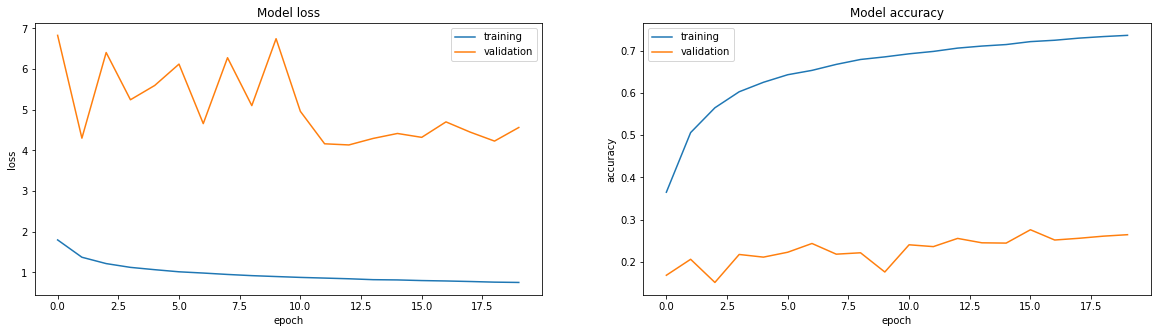

313/313 [==============================] - 2s 7ms/step - loss: 4.5628 - accuracy: 0.2644
Validation Accuracy: 0.26440000534057617


In [ ]:
# YOUR CODE HERE
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# add batchnormalization layer
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# add batchnormalization layer
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# add batchnormalization layer
model.add(tf.keras.layers.BatchNormalization())
model.add(layers.Flatten())
model.add(tf.keras.layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(layers.Dense(10, activation='softmax'))

# set preprocesing dictionary
preprocess = {'featurewise_center': True, 'featurewise_std_normalization' : True}

# augment data 
augment = {'horizontal_flip': True, 'zoom_range': 0.1, 'zca_whitening': True, 'fill_mode': 'reflect'}

# run training and evaluati8on function
train_and_evaluate(model, train_images, train_labels, test_images, test_labels, preprocess, epochs = 20, augment = augment)

**Q10. Explain why you would want to apply the augmentation to your training, but not your validation data. What would happen if the function did apply the augmentation to both?**

*Data augmentation is done only on training set as it helps the model become more generalized and robust. I liked the way Wouter explained it to me, in the sense that its similar to training a ninja (or pirate) with blindfolds so that it preforms even better when it does not have the blindfolds. The point is, you apply it to the training set to improve the model, and then refrain from applying it to the validation data in order to test the model in its optimum state. In this way, you don't want to apply it to the validation data because you only want to validate how well the model operates with actual data. *

**Q11. Which augmentations did you try? Which augmentations gave the best results? Can you think of a reason why these augmentations specifically would be effective for the CIFAR-10 images?**

*First, I applied horizontal_flip' and 'zoom_range'. This increased the accuracy somewhat. like 0.1 %. 

Then, I applied ZCA whitening and I set the reflect mode so that Points outside the boundaries of the input are filled according to the reflect mode. 

The accuracy decreased to 0.2644.

The reflect mode did not make much of a difference. This could be expected because it only concerns the edges and when we worked with the edges last week for CNN, we learned that the particular mode ussually does not affect the performance of the model. 

The ZCA whitening appears to make the most difference and causes the sharp decrease. as shown above. Maybe the whitening is too much. So, I would refrain from using it.*